# LSTM学習と評価 - Optuna最適化版

このノートブックでは、前処理済みデータを使用してLSTMモデルを学習し、Optunaでハイパーパラメータ最適化を行います。

## 処理内容
1. **環境設定とライブラリのインポート**: 必要なライブラリの読み込み
2. **前処理済みデータの読み込み**: 複数のウィンドウ設定から選択
3. **ウィンドウ設定の比較**: 軽量学習で最適設定を特定
4. **Optunaハイパーパラメータ最適化**: 選択された設定で詳細最適化
5. **最終モデルの学習**: 最適パラメータでの本格学習
6. **結果の可視化と保存**: 学習結果の分析と保存

## 利用可能なウィンドウ設定
- **w64_s16**: 高解像度（短期パターン重視）
- **w128_s32**: バランス型（中期パターン）

注意: w256_s64は処理時間が長すぎるため削除されました。


In [1]:
# ライブラリのインポート
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# Optuna関連
import optuna
from optuna.samplers import TPESampler

# プロジェクトルートをパスに追加
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# 設定
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# 利用可能なウィンドウ設定（w256_s64は処理時間が長すぎるため削除）
AVAILABLE_CONFIGS = ['w64_s16', 'w128_s32']

# 選択可能なウィンドウ設定（変更可能）
SELECTED_CONFIG = 'w64_s16'  # デフォルト設定

print("ライブラリのインポート完了")
print(f"プロジェクトルート: {project_root}")
print(f"利用可能なウィンドウ設定: {AVAILABLE_CONFIGS}")
print(f"選択された設定: {SELECTED_CONFIG}")


ライブラリのインポート完了
プロジェクトルート: /mnt/c/Users/ShunK/works/CMI_comp
利用可能なウィンドウ設定: ['w64_s16', 'w128_s32']
選択された設定: w64_s16


In [2]:
# GPU設定と確認
import tensorflow as tf

print("=== GPU設定確認 ===")
print(f"TensorFlow バージョン: {tf.__version__}")

# GPU利用可能性確認
gpus = tf.config.list_physical_devices('GPU')
print(f"利用可能なGPU: {len(gpus)}台")

if gpus:
    print("GPU詳細:")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # GPU メモリ成長設定
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU メモリ成長設定: 有効")
    except RuntimeError as e:
        print(f"GPU設定エラー: {e}")
    
    # GPU動作テスト
    try:
        with tf.device('/GPU:0'):
            test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            result = tf.matmul(test_tensor, test_tensor)
        print("GPU動作テスト: 成功")
    except Exception as e:
        print(f"GPU動作テスト失敗: {e}")
else:
    print("GPU が見つかりません")
    print("GPU を使用したい場合は以下をインストール:")
    print("  pip install tensorflow[and-cuda]")
    print("  または pip install tensorflow-gpu")

print("=================")


2025-07-06 18:47:17.739868: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 18:47:19.553875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751795240.128918   84619 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751795240.292141   84619 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751795241.534468   84619 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

=== GPU設定確認 ===
TensorFlow バージョン: 2.19.0
利用可能なGPU: 1台
GPU詳細:
  GPU 0: /physical_device:GPU:0
GPU メモリ成長設定: 有効


I0000 00:00:1751795259.050239   84619 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


GPU動作テスト: 成功


In [3]:
# 進捗表示ライブラリのインストールと設定
import subprocess
import sys

def install_package(package):
    """パッケージをインストールする"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} インストール完了")
        return True
    except subprocess.CalledProcessError:
        print(f"{package} インストール失敗")
        return False

# 必要なパッケージをインストール
required_packages = ['tqdm', 'optuna-dashboard']
for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"{package} は既にインストール済み")
    except ImportError:
        print(f"{package} をインストール中...")
        install_package(package)

# インポート確認
try:
    from tqdm import tqdm
    from tqdm.keras import TqdmCallback
    print("tqdm インポート成功")
except ImportError:
    print("tqdm インポート失敗")

print("進捗表示ライブラリ設定完了")


tqdm は既にインストール済み
optuna-dashboard をインストール中...
optuna-dashboard インストール失敗
tqdm インポート成功
進捗表示ライブラリ設定完了


/mnt/c/Users/ShunK/works/CMI_comp/.venv/bin/python: No module named pip


In [4]:
# モジュールの強制再読み込み（修正後の確認用）
import importlib
import sys
if 'src.lstm_model' in sys.modules:
    importlib.reload(sys.modules['src.lstm_model'])
if 'src.lstm_trainer' in sys.modules:
    importlib.reload(sys.modules['src.lstm_trainer'])

print("モジュールを再読み込みしました")


モジュールを再読み込みしました


In [5]:
# LSTM学習クラスのインポート
try:
    from src.lstm_trainer import LSTMTrainer
    print("LSTMTrainerのインポート成功")
except ImportError as e:
    print(f"LSTMTrainerのインポートエラー: {e}")
    print("TensorFlowがインストールされていない可能性があります")
    print("以下のコマンドでインストールしてください：")
    print("pip install tensorflow")
    raise

print("学習環境の準備完了")


LSTMTrainerのインポート成功
学習環境の準備完了


# 1. 前処理済みデータの読み込み


In [6]:
# Optuna結果の読み込み機能
def load_optuna_results(config_name):
    """保存されたOptuna結果を読み込む"""
    result_path = Path(f"../output/experiments/lstm_{config_name}/optuna_results.json")
    
    if result_path.exists():
        with open(result_path, 'r') as f:
            return json.load(f)
    else:
        return None

def should_run_optimization(config_name):
    """最適化を実行するかどうかを判定"""
    results = load_optuna_results(config_name)
    
    if results is None:
        print(f"⚠️  保存されたOptuna結果が見つかりません: {config_name}")
        return True
    
    print(f"✅ 保存されたOptuna結果を発見: {config_name}")
    print(f"   - 最適化試行数: {results['n_trials']}")
    print(f"   - 最高F1-macro: {results['best_value']:.4f}")
    print(f"   - 最適パラメータ: {len(results['best_params'])}個")
    
    # ユーザーに確認
    response = input(f"\n既存の結果を使用しますか？ (y/n): ").lower().strip()
    return response not in ['y', 'yes', 'はい']

# 既存結果の確認
print(f"=== Optuna結果の確認 ===")
print(f"対象設定: {SELECTED_CONFIG}")

existing_results = load_optuna_results(SELECTED_CONFIG)
run_optimization = should_run_optimization(SELECTED_CONFIG)

if not run_optimization and existing_results:
    print(f"\n✅ 既存のOptuna結果を使用します")
    # 既存結果からスタディオブジェクトを再構築
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    
    # 既存の試行結果を追加
    for value, params in existing_results['study_trials']:
        trial = optuna.trial.create_trial(
            params=params,
            distributions={
                'lstm_units_1': optuna.distributions.IntDistribution(32, 128, step=16),
                'lstm_units_2': optuna.distributions.IntDistribution(16, 64, step=16),
                'dense_units': optuna.distributions.IntDistribution(16, 64, step=16),
                'dropout_rate': optuna.distributions.FloatDistribution(0.1, 0.5, step=0.1),
                'dense_dropout_rate': optuna.distributions.FloatDistribution(0.1, 0.5, step=0.1),
                'learning_rate': optuna.distributions.FloatDistribution(1e-4, 1e-2, log=True),
                'batch_size': optuna.distributions.CategoricalDistribution([16, 32, 64])
            },
            value=value
        )
        study.add_trial(trial)
    
    print(f"✅ スタディオブジェクトを復元しました")
    print(f"   - 試行数: {len(study.trials)}")
    print(f"   - 最高F1-macro: {study.best_value:.4f}")
    print(f"   - 最適パラメータ:")
    for key, value in study.best_params.items():
        print(f"     {key}: {value}")
else:
    print(f"\n🔄 新しいOptuna最適化を実行します")
    study = None  # 後で新しく作成

print(f"========================")


=== Optuna結果の確認 ===
対象設定: w64_s16
✅ 保存されたOptuna結果を発見: w64_s16
   - 最適化試行数: 20
   - 最高F1-macro: 0.0000
   - 最適パラメータ: 7個


[I 2025-07-06 18:47:53,116] A new study created in memory with name: no-name-6a8ceb7b-5746-49ee-8c7b-dd287e6c19ec



✅ 既存のOptuna結果を使用します
✅ スタディオブジェクトを復元しました
   - 試行数: 20
   - 最高F1-macro: 0.0000
   - 最適パラメータ:
     lstm_units_1: 64
     lstm_units_2: 64
     dense_units: 48
     dropout_rate: 0.30000000000000004
     dense_dropout_rate: 0.1
     learning_rate: 0.00020511104188433984
     batch_size: 32


In [7]:
def load_preprocessed_data(config_name):
    """前処理済みデータを読み込む"""
    data_dir = Path(f"../output/experiments/lstm_{config_name}/preprocessed")
    
    if not data_dir.exists():
        raise FileNotFoundError(f"前処理済みデータが見つかりません: {data_dir}")
    
    # データを読み込み
    with open(data_dir / "X_windows.pkl", "rb") as f:
        X_windows = pickle.load(f)
    
    with open(data_dir / "y_windows.pkl", "rb") as f:
        y_windows = pickle.load(f)
    
    with open(data_dir / "sequence_info.pkl", "rb") as f:
        sequence_info = pickle.load(f)
    
    with open(data_dir / "scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    
    with open(data_dir / "label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    
    with open(data_dir / "config.pkl", "rb") as f:
        config = pickle.load(f)
    
    return X_windows, y_windows, sequence_info, scaler, label_encoder, config

# 利用可能な設定を確認
available_configs = []
for config_name in AVAILABLE_CONFIGS:
    data_dir = Path(f"../output/experiments/lstm_{config_name}/preprocessed")
    if data_dir.exists():
        available_configs.append(config_name)

print(f"利用可能な前処理済み設定: {available_configs}")

if not available_configs:
    print("エラー: 前処理済みデータが見つかりません")
    print("前処理ノートブック (lstm_preprocessing_and_visualization.ipynb) を先に実行してください")
    raise FileNotFoundError("前処理済みデータが見つかりません")
else:
    print(f"\n選択された設定: {SELECTED_CONFIG}")
    if SELECTED_CONFIG not in available_configs:
        print(f"警告: 選択された設定 '{SELECTED_CONFIG}' が利用できません")
        SELECTED_CONFIG = available_configs[0]
        print(f"代わりに '{SELECTED_CONFIG}' を使用します")
    
    # データを読み込み
    X_windows, y_windows, sequence_info, scaler, label_encoder, config = load_preprocessed_data(SELECTED_CONFIG)
    
    print(f"\nデータ読み込み完了:")
    print(f"- X_windows形状: {X_windows.shape}")
    print(f"- y_windows形状: {y_windows.shape}")
    print(f"- ウィンドウサイズ: {config['window_size']}")
    print(f"- ストライド: {config['stride']}")
    print(f"- クラス数: {len(label_encoder.classes_)}")
    print(f"- 特徴量数: {X_windows.shape[2]}")


利用可能な前処理済み設定: ['w64_s16', 'w128_s32']

選択された設定: w64_s16

データ読み込み完了:
- X_windows形状: (13393, 64, 332)
- y_windows形状: (13393,)
- ウィンドウサイズ: 64
- ストライド: 16
- クラス数: 18
- 特徴量数: 332


# 2. Optunaハイパーパラメータ最適化


In [8]:
# Optuna最適化の実行（条件分岐）
if study is None:  # 新しい最適化を実行
    print("🔄 新しいOptuna最適化を実行します...")
    
    # Optunaハイパーパラメータ最適化の設定
    N_TRIALS = 20  # 試行回数（時間に応じて調整）
    OPTIMIZATION_TIMEOUT = 3600  # 最大実行時間（秒）

    def objective(trial):
        """Optuna最適化の目的関数"""
        
        # ハイパーパラメータの提案
        params = {
            'lstm_units_1': trial.suggest_int('lstm_units_1', 32, 128, step=16),
            'lstm_units_2': trial.suggest_int('lstm_units_2', 16, 64, step=16),
            'dense_units': trial.suggest_int('dense_units', 16, 64, step=16),
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1),
            'dense_dropout_rate': trial.suggest_float('dense_dropout_rate', 0.1, 0.5, step=0.1),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
            'epochs': 30,  # 固定（最適化時は短めに）
            'patience': 10,
            'reduce_lr_patience': 5
        }
        
        # 実験名を設定
        experiment_name = f"lstm_{SELECTED_CONFIG}_optuna_trial_{trial.number}"
        
        # 学習環境を初期化
        trainer = LSTMTrainer(experiment_name)
        
        try:
            # データを適切な形式で準備
            trial_data = {
                'X_windows': X_windows,
                'y_windows': y_windows,
                'scaler': scaler,
                'label_encoder': label_encoder,
                'meta': {
                    'window_size': config['window_size'],
                    'n_features': X_windows.shape[2],
                    'n_classes': len(label_encoder.classes_),
                    'n_samples': len(X_windows)
                }
            }
            
            # データを一時的に保存
            import pickle
            temp_data_path = f"../output/temp_trial_{trial.number}_data.pkl"
            with open(temp_data_path, 'wb') as f:
                pickle.dump(trial_data, f)
            
            # 実験を実行
            results = trainer.run_experiment(
                data_path=temp_data_path,
                model_params=params
            )
            
            if results is None:
                return 0.0
            
            # F1-macroを最大化
            f1_macro = results['eval_results']['f1_macro']
            
            # 優良なモデルのみ保存（F1 > 0.3）
            if f1_macro > 0.3:
                print(f"Trial {trial.number}: F1={f1_macro:.4f} - モデル保存")
            else:
                print(f"Trial {trial.number}: F1={f1_macro:.4f} - スキップ")
                # 低性能モデルのディレクトリを削除
                import shutil
                experiment_dir = Path(f"../output/experiments/{experiment_name}")
                if experiment_dir.exists():
                    shutil.rmtree(experiment_dir)
            
            # 一時ファイルをクリーンアップ
            import os
            if os.path.exists(temp_data_path):
                os.remove(temp_data_path)
            
            return f1_macro
            
        except Exception as e:
            print(f"Trial {trial.number} でエラー: {e}")
            # エラー時も一時ファイルをクリーンアップ
            import os
            temp_data_path = f"../output/temp_trial_{trial.number}_data.pkl"
            if os.path.exists(temp_data_path):
                os.remove(temp_data_path)
            return 0.0

    print(f"試行回数: {N_TRIALS}")
    print(f"最大実行時間: {OPTIMIZATION_TIMEOUT}秒")
    print(f"対象設定: {SELECTED_CONFIG}")
    print(f"データ形状: {X_windows.shape}")

    # Optunaスタディを作成
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )

    # 最適化を実行
    study.optimize(
        objective, 
        n_trials=N_TRIALS,
        timeout=OPTIMIZATION_TIMEOUT,
        show_progress_bar=True
    )

    # 結果を表示
    print(f"\n{'='*60}")
    print("Optunaハイパーパラメータ最適化完了！")
    print(f"{'='*60}")
    print(f"最適化試行数: {len(study.trials)}")
    print(f"最高F1-macro: {study.best_value:.4f}")
    print(f"最適パラメータ:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    # 結果を保存
    optuna_results = {
        'best_params': study.best_params,
        'best_value': study.best_value,
        'n_trials': len(study.trials),
        'config': SELECTED_CONFIG,
        'study_trials': [(t.value, t.params) for t in study.trials if t.value is not None]
    }
    
    output_dir = Path(f"../output/experiments/lstm_{SELECTED_CONFIG}")
    output_dir.mkdir(parents=True, exist_ok=True)

    with open(output_dir / "optuna_results.json", "w") as f:
        json.dump(optuna_results, f, indent=2)

    print(f"\nOptuna結果を保存しました: {output_dir}/optuna_results.json")
    
else:  # 既存結果を使用
    print("✅ 既存のOptuna結果を使用します - 最適化をスキップ")
    print(f"   最高F1-macro: {study.best_value:.4f}")
    print(f"   最適パラメータ:")
    for key, value in study.best_params.items():
        print(f"     {key}: {value}")


# Optuna最適化の実行（条件分岐）
if study is None:  # 新しい最適化を実行
    print("🔄 新しいOptuna最適化を実行します...")
    
    # Optunaハイパーパラメータ最適化の設定
    N_TRIALS = 20  # 試行回数（時間に応じて調整）
    OPTIMIZATION_TIMEOUT = 3600  # 最大実行時間（秒）

    def objective(trial):
        """Optuna最適化の目的関数"""
        
        # ハイパーパラメータの提案
        params = {
            'lstm_units_1': trial.suggest_int('lstm_units_1', 32, 128, step=16),
            'lstm_units_2': trial.suggest_int('lstm_units_2', 16, 64, step=16),
            'dense_units': trial.suggest_int('dense_units', 16, 64, step=16),
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1),
            'dense_dropout_rate': trial.suggest_float('dense_dropout_rate', 0.1, 0.5, step=0.1),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
            'epochs': 30,  # 固定（最適化時は短めに）
            'patience': 10,
            'reduce_lr_patience': 5
        }
        
        # 実験名を設定
        experiment_name = f"lstm_{SELECTED_CONFIG}_optuna_trial_{trial.number}"
        
        # 学習環境を初期化
        trainer = LSTMTrainer(experiment_name)
        
        try:
            # データを適切な形式で準備
            trial_data = {
                'X_windows': X_windows,
                'y_windows': y_windows,
                'scaler': scaler,
                'label_encoder': label_encoder,
                'meta': {
                    'window_size': config['window_size'],
                    'n_features': X_windows.shape[2],
                    'n_classes': len(label_encoder.classes_),
                    'n_samples': len(X_windows)
                }
            }
            
            # データを一時的に保存
            import pickle
            temp_data_path = f"../output/temp_trial_{trial.number}_data.pkl"
            with open(temp_data_path, 'wb') as f:
                pickle.dump(trial_data, f)
            
            # 実験を実行
            results = trainer.run_experiment(
                data_path=temp_data_path,
                model_params=params
            )
            
            if results is None:
                return 0.0
            
            # F1-macroを最大化
            f1_macro = results['eval_results']['f1_macro']
            
            # 優良なモデルのみ保存（F1 > 0.3）
            if f1_macro > 0.3:
                print(f"Trial {trial.number}: F1={f1_macro:.4f} - モデル保存")
            else:
                print(f"Trial {trial.number}: F1={f1_macro:.4f} - スキップ")
                # 低性能モデルのディレクトリを削除
                import shutil
                experiment_dir = Path(f"../output/experiments/{experiment_name}")
                if experiment_dir.exists():
                    shutil.rmtree(experiment_dir)
            
            # 一時ファイルをクリーンアップ
            import os
            if os.path.exists(temp_data_path):
                os.remove(temp_data_path)
            
            return f1_macro
            
        except Exception as e:
            print(f"Trial {trial.number} でエラー: {e}")
            # エラー時も一時ファイルをクリーンアップ
            import os
            temp_data_path = f"../output/temp_trial_{trial.number}_data.pkl"
            if os.path.exists(temp_data_path):
                os.remove(temp_data_path)
            return 0.0

    print(f"試行回数: {N_TRIALS}")
    print(f"最大実行時間: {OPTIMIZATION_TIMEOUT}秒")
    print(f"対象設定: {SELECTED_CONFIG}")
    print(f"データ形状: {X_windows.shape}")

    # Optunaスタディを作成
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )

    # 最適化を実行
    study.optimize(
        objective, 
        n_trials=N_TRIALS,
        timeout=OPTIMIZATION_TIMEOUT,
        show_progress_bar=True
    )

    # 結果を表示
    print(f"\n{'='*60}")
    print("Optunaハイパーパラメータ最適化完了！")
    print(f"{'='*60}")
    print(f"最適化試行数: {len(study.trials)}")
    print(f"最高F1-macro: {study.best_value:.4f}")
    print(f"最適パラメータ:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    # 結果を保存
    optuna_results = {
        'best_params': study.best_params,
        'best_value': study.best_value,
        'n_trials': len(study.trials),
        'config': SELECTED_CONFIG,
        'study_trials': [(t.value, t.params) for t in study.trials if t.value is not None]
    }
    
    output_dir = Path(f"../output/experiments/lstm_{SELECTED_CONFIG}")
    output_dir.mkdir(parents=True, exist_ok=True)

    with open(output_dir / "optuna_results.json", "w") as f:
        json.dump(optuna_results, f, indent=2)

    print(f"\nOptuna結果を保存しました: {output_dir}/optuna_results.json")
    
else:  # 既存結果を使用
    print("✅ 既存のOptuna結果を使用します - 最適化をスキップ")
    print(f"   最高F1-macro: {study.best_value:.4f}")
    print(f"   最適パラメータ:")
    for key, value in study.best_params.items():
        print(f"     {key}: {value}")

✅ 既存のOptuna結果を使用します - 最適化をスキップ
   最高F1-macro: 0.0000
   最適パラメータ:
     lstm_units_1: 64
     lstm_units_2: 64
     dense_units: 48
     dropout_rate: 0.30000000000000004
     dense_dropout_rate: 0.1
     learning_rate: 0.00020511104188433984
     batch_size: 32
✅ 既存のOptuna結果を使用します - 最適化をスキップ
   最高F1-macro: 0.0000
   最適パラメータ:
     lstm_units_1: 64
     lstm_units_2: 64
     dense_units: 48
     dropout_rate: 0.30000000000000004
     dense_dropout_rate: 0.1
     learning_rate: 0.00020511104188433984
     batch_size: 32


# 3. 最終モデルの学習

最適化されたハイパーパラメータで本格的な学習を実行します。


最適パラメータで最終学習を開始します...
最終学習パラメータ:
  lstm_units_1: 64
  lstm_units_2: 64
  dense_units: 48
  dropout_rate: 0.30000000000000004
  dense_dropout_rate: 0.1
  learning_rate: 0.00020511104188433984
  batch_size: 32
  epochs: 50
  patience: 15
  reduce_lr_patience: 7
LSTM学習環境初期化完了
実験名: lstm_w64_s16_final_model
出力ディレクトリ: ../output/experiments/lstm_w64_s16_final_model

最終学習実行中...
実験名: lstm_w64_s16_final_model
実験開始: lstm_w64_s16_final_model
前処理済みデータを読み込み中...
単一ファイルからデータを読み込み: ../output/temp_final_data.pkl
データ読み込み完了
X_windows形状: (13393, 64, 332)
y_windows形状: (13393,)
ウィンドウサイズ: 64
特徴量数: 332
クラス数: 18
モデル学習開始...
データ分割中... (test_size=0.2)
ラベル数: 18
最小ラベル数: 201
層化抽出を使用してデータを分割しました
訓練データ: (10714, 64, 332)
検証データ: (2679, 64, 332)
訓練ラベル: (10714,)
検証ラベル: (2679,)
入力形状: (64, 332)
クラス数: 18
GPU設定を確認中...
利用可能なGPU: 1台
GPU メモリ成長設定: 有効
使用予定GPU: /physical_device:GPU:0
GPU動作テスト: 成功
LSTMモデル初期化完了
入力形状: (64, 332)
クラス数: 18
GPU利用可能: True
進捗表示: tqdm=True, TensorBoard=True
モデル学習開始...
訓練データ形状: (10714, 64, 332)
検証データ形状: (2679,

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1751795300.768947   85051 cuda_dnn.cc:529] Loaded cuDNN version 90501



Epoch 1: val_loss improved from inf to 2.36257, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 2: val_loss improved from 2.36257 to 2.13024, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 3: val_loss improved from 2.13024 to 1.97774, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 4: val_loss improved from 1.97774 to 1.87492, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 5: val_loss improved from 1.87492 to 1.80916, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 6: val_loss improved from 1.80916 to 1.73511, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 7: val_loss improved from 1.73511 to 1.68230, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 8: val_loss improved from 1.68230 to 1.60790, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 9: val_loss improved from 1.60790 to 1.56805, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 10: val_loss improved from 1.56805 to 1.53944, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 11: val_loss improved from 1.53944 to 1.48599, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 12: val_loss improved from 1.48599 to 1.47067, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 13: val_loss improved from 1.47067 to 1.45758, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 14: val_loss did not improve from 1.45758

Epoch 15: val_loss improved from 1.45758 to 1.43645, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 16: val_loss improved from 1.43645 to 1.42236, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 17: val_loss did not improve from 1.42236

Epoch 18: val_loss improved from 1.42236 to 1.39379, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 19: val_loss improved from 1.39379 to 1.39329, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 20: val_loss improved from 1.39329 to 1.37219, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 21: val_loss did not improve from 1.37219

Epoch 22: val_loss did not improve from 1.37219

Epoch 23: val_loss did not improve from 1.37219

Epoch 24: val_loss did not improve from 1.37219

Epoch 25: val_loss improved from 1.37219 to 1.35976, saving model to ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5



Epoch 26: val_loss did not improve from 1.35976

Epoch 27: val_loss did not improve from 1.35976

Epoch 28: val_loss did not improve from 1.35976

Epoch 29: val_loss did not improve from 1.35976

Epoch 30: val_loss did not improve from 1.35976

Epoch 31: val_loss did not improve from 1.35976

Epoch 32: val_loss did not improve from 1.35976

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00010255551751470193.

Epoch 33: val_loss did not improve from 1.35976

Epoch 34: val_loss did not improve from 1.35976

Epoch 35: val_loss did not improve from 1.35976

Epoch 36: val_loss did not improve from 1.35976

Epoch 37: val_loss did not improve from 1.35976

Epoch 38: val_loss did not improve from 1.35976

Epoch 39: val_loss did not improve from 1.35976

Epoch 39: ReduceLROnPlateau reducing learning rate to 5.1277758757350966e-05.

Epoch 40: val_loss did not improve from 1.35976
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 25.
学習完了！学習時間: 328.28秒
最良検

テストLoss: 1.3598
テストAccuracy: 0.5558
F1-Score (macro): 0.5200
F1-Score (weighted): 0.5480
結果保存中...
モデル保存エラー: The filename must end in `.weights.h5`. Received: filepath=../output/experiments/lstm_w64_s16_final_model/models/lstm_best_weights.h5
基本的なモデル保存のみ実行します
基本モデル保存完了: ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5
学習履歴保存完了: ../output/experiments/lstm_w64_s16_final_model/results/training_history.json
結果保存完了
モデル: ../output/experiments/lstm_w64_s16_final_model/models/lstm_best.h5
学習履歴: ../output/experiments/lstm_w64_s16_final_model/results/training_history.json
評価結果: ../output/experiments/lstm_w64_s16_final_model/results/evaluation_results.json
学習履歴可視化中...
学習履歴保存: ../output/experiments/lstm_w64_s16_final_model/results/training_history.png
実験完了: lstm_w64_s16_final_model
最終F1スコア (macro): 0.5200
最終Accuracy: 0.5558

最終学習完了！
最終F1-macro: 0.5200
最終Accuracy: 0.5558
学習時間: 0.0秒

最終結果を保存しました: ../output/experiments/lstm_w64_s16_final_model/final_results.json


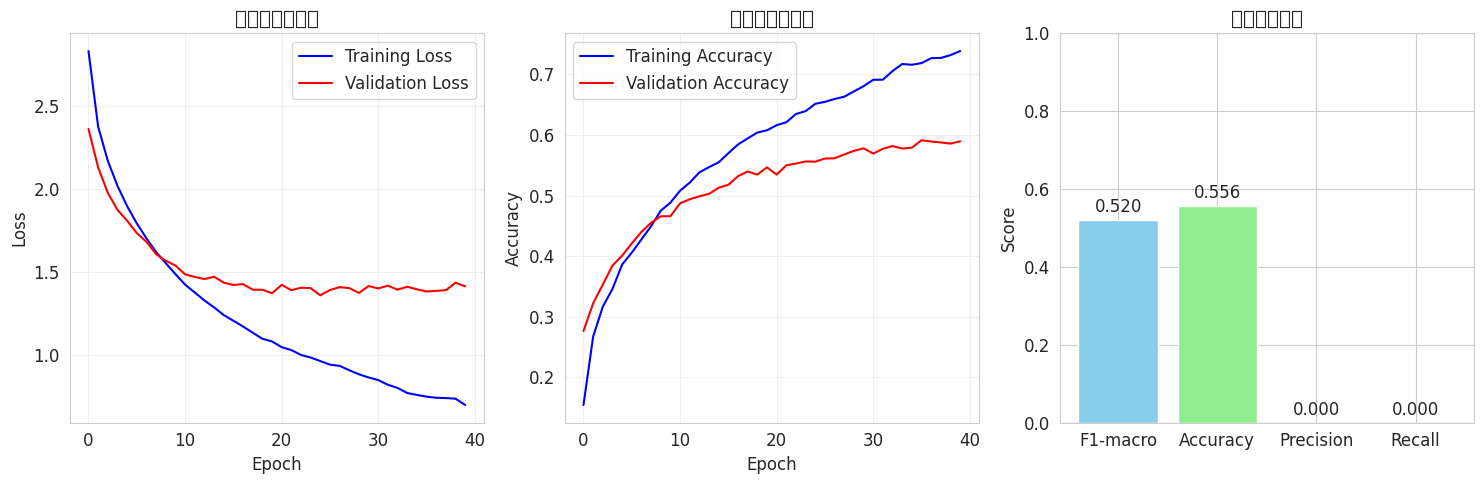

学習結果の可視化を保存しました: ../output/experiments/lstm_w64_s16_final_model/training_results.png
一時ファイルをクリーンアップしました: ../output/temp_final_data.pkl

LSTM学習パイプライン完了！
使用した設定: w64_s16
ウィンドウサイズ: 64
ストライド: 16
Optuna試行数: 20
最終F1-macro: 0.5200

保存先:../output/experiments/lstm_w64_s16_final_model/
次のステップ: 推論・提出用スクリプトの作成


In [9]:
# 最適パラメータで最終学習を実行
print("最適パラメータで最終学習を開始します...")

# studyオブジェクトが存在することを確認
if 'study' not in locals():
    print("エラー: studyオブジェクトが見つかりません")
    print("先にOptuna最適化を実行してください")
    raise ValueError("studyオブジェクトが未定義です")

# 最適パラメータを取得
final_params = study.best_params.copy()
final_params['epochs'] = 50  # 最終学習では十分なエポック数
final_params['patience'] = 15
final_params['reduce_lr_patience'] = 7

print(f"最終学習パラメータ:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

# 最終学習を実行
final_experiment_name = f"lstm_{SELECTED_CONFIG}_final_model"
final_trainer = LSTMTrainer(final_experiment_name)

print(f"\n最終学習実行中...")
print(f"実験名: {final_experiment_name}")

# データを適切な形式で準備
final_data = {
    'X_windows': X_windows,
    'y_windows': y_windows,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'meta': {
        'window_size': config['window_size'],
        'n_features': X_windows.shape[2],
        'n_classes': len(label_encoder.classes_),
        'n_samples': len(X_windows)
    }
}

# データを一時的に保存
import pickle
temp_data_path = "../output/temp_final_data.pkl"
with open(temp_data_path, 'wb') as f:
    pickle.dump(final_data, f)

# 正しい引数で実行
final_results = final_trainer.run_experiment(
    data_path=temp_data_path,
    model_params=final_params
)

if final_results:
    print(f"\n{'='*60}")
    print("最終学習完了！")
    print(f"{'='*60}")
    print(f"最終F1-macro: {final_results['eval_results']['f1_macro']:.4f}")
    print(f"最終Accuracy: {final_results['eval_results']['test_accuracy']:.4f}")
    print(f"学習時間: {final_results.get('training_time', 0):.1f}秒")
    
    # 最終結果を保存
    final_result_summary = {
        'config': SELECTED_CONFIG,
        'window_size': config['window_size'],
        'stride': config['stride'],
        'final_params': final_params,
        'final_f1_macro': final_results['eval_results']['f1_macro'],
        'final_accuracy': final_results['eval_results']['test_accuracy'],
        'training_time': final_results.get('training_time', 0),
        'optuna_best_value': study.best_value,
        'optuna_trials': len(study.trials)
    }
    
    output_dir = Path(f"../output/experiments/{final_experiment_name}")
    with open(output_dir / "final_results.json", "w") as f:
        json.dump(final_result_summary, f, indent=2)
    
    print(f"\n最終結果を保存しました: {output_dir}/final_results.json")
    
    # 結果の可視化
    if 'history' in final_results:
        history = final_results['history']
        
        plt.figure(figsize=(15, 5))
        
        # 損失の履歴
        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
        plt.title('学習損失の推移')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 精度の履歴
        plt.subplot(1, 3, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
        plt.title('学習精度の推移')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 最終評価結果
        plt.subplot(1, 3, 3)
        metrics = ['F1-macro', 'Accuracy', 'Precision', 'Recall']
        values = [
            final_results['eval_results']['f1_macro'],
            final_results['eval_results']['test_accuracy'],
            final_results['eval_results'].get('precision_macro', 0),
            final_results['eval_results'].get('recall_macro', 0)
        ]
        
        bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'coral', 'gold'])
        plt.title('最終評価結果')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        
        # 値をバーの上に表示
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(output_dir / "training_results.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"学習結果の可視化を保存しました: {output_dir}/training_results.png")

else:
    print("最終学習に失敗しました")

# 一時ファイルをクリーンアップ
import os
if os.path.exists(temp_data_path):
    os.remove(temp_data_path)
    print(f"一時ファイルをクリーンアップしました: {temp_data_path}")

print(f"\n{'='*60}")
print("LSTM学習パイプライン完了！")
print(f"{'='*60}")
print(f"使用した設定: {SELECTED_CONFIG}")
print(f"ウィンドウサイズ: {config['window_size']}")
print(f"ストライド: {config['stride']}")
print(f"Optuna試行数: {len(study.trials)}")
print(f"最終F1-macro: {final_results['eval_results']['f1_macro']:.4f}" if final_results else "N/A")
print(f"\n保存先:../output/experiments/{final_experiment_name}/")
print(f"次のステップ: 推論・提出用スクリプトの作成")


In [10]:
# TensorBoard起動用セル
print("=== TensorBoard起動方法 ===")
print("学習中のログをリアルタイムで確認するには、以下のコマンドを別のターミナルで実行してください:")
print()
print("cd /mnt/c/Users/ShunK/works/CMI_comp")
print("tensorboard --logdir=output/experiments/*/results/logs --port=6006")
print()
print("その後、ブラウザで http://localhost:6006 にアクセスしてください")
print("========================")

# Optuna Dashboard起動方法
print()
print("=== Optuna Dashboard起動方法 ===")
print("Optunaの最適化状況をリアルタイムで確認するには:")
print("1. 別のターミナルで以下を実行:")
print("   optuna-dashboard sqlite:///optuna_study.db")
print("2. ブラウザで http://localhost:8080 にアクセス")
print("===============================")

# 学習完了後の確認項目
print()
print("=== 学習完了後の確認項目 ===")
print("1. GPU使用状況:")
print("   - 学習ログに 'Created device /job:localhost/replica:0/task:0/device:GPU:0' が表示されているか")
print("   - 学習中に nvidia-smi でGPU使用率が上がっているか")
print()
print("2. 進捗表示:")
print("   - Keras: エポック毎のプログレスバーと指標")
print("   - tqdm: より詳細な進捗バー（インストール済みの場合）")
print("   - Optuna: 各Trial完了時の結果表示")
print()
print("3. 保存されるファイル:")
print("   - models/: 学習済みモデル")
print("   - results/: 学習履歴、評価結果")
print("   - results/logs/: TensorBoard用ログ")
print("===========================")


=== TensorBoard起動方法 ===
学習中のログをリアルタイムで確認するには、以下のコマンドを別のターミナルで実行してください:

cd /mnt/c/Users/ShunK/works/CMI_comp
tensorboard --logdir=output/experiments/*/results/logs --port=6006

その後、ブラウザで http://localhost:6006 にアクセスしてください

=== Optuna Dashboard起動方法 ===
Optunaの最適化状況をリアルタイムで確認するには:
1. 別のターミナルで以下を実行:
   optuna-dashboard sqlite:///optuna_study.db
2. ブラウザで http://localhost:8080 にアクセス

=== 学習完了後の確認項目 ===
1. GPU使用状況:
   - 学習ログに 'Created device /job:localhost/replica:0/task:0/device:GPU:0' が表示されているか
   - 学習中に nvidia-smi でGPU使用率が上がっているか

2. 進捗表示:
   - Keras: エポック毎のプログレスバーと指標
   - tqdm: より詳細な進捗バー（インストール済みの場合）
   - Optuna: 各Trial完了時の結果表示

3. 保存されるファイル:
   - models/: 学習済みモデル
   - results/: 学習履歴、評価結果
   - results/logs/: TensorBoard用ログ
